In [1]:
# IMPORTS
using FFTW, Plots
using DSP: unwrap

In [2]:
# CONSTANTS
c = 299792458

# Waveguide
fr = 0.18
τl = 32e-15
τvib = 12.2e-15
L = 0.5
α = 0.0
γ = 0.11
λc = 835e-9
ω0 = 2π*c/λc

# Signal 
T = 12.5e-12 # Duration
N = 2^13 # Time samples

τ = 0.05e-12/ (2log(1+sqrt(2)))
P = 10000
# Vectors 
βs = [0.0, -1.1830e-026]
t = T*(-N÷2:N÷2-1)/N;
ν = fftshift((-N÷2:N÷2-1)./T);
ω = 2π.*ν;
dt = t[2]-t[1]


@show LD = τ.^2 / (abs(βs[2]))
@show LNL = LD / (3^2)

@show P = 1 / (LNL * γ)

u0 = sqrt(P)*sech.(t ./ τ);

LD = τ .^ 2 / abs(βs[2]) = 0.06801038131656875
LNL = LD / 3 ^ 2 = 0.007556709035174306
P = 1 / (LNL * γ) = 1203.0248946457414


In [3]:


# Simulation parameters 

dz = L/10  # in percent 
reltol = 1e-6
maxiters = 1000
zk = 0
it = 0
k5 = nothing
zs = []
ϵ_hist = []
u = ComplexF64.(u0)


FFT = plan_fft(u)
IFFT = plan_ifft(u)

hr = ( τvib^2 +  τl^2) / τvib / τl^2 * exp.(-t / τl) .* sin.(t / τvib)
hr[t.<0] .= 0.0
RW = FFT * reverse(hr)




NL1(u) = 1.0im .* γ * FFT * (u .* abs2.(u))

function NL2(u)
	IW = FFT * (u .* abs2.(u))
	return 1.0im .* γ * (1 .+ ω/ω0) .* IW
end


# contruct NL function with meta programming (GNLSE can be reduce to NLSE w and w/ self steepening)
function NL3_lol(u)
	
	η = 1 .+ ω/ω0
	IT = abs2.(u)
	RS = dt*fr*(ifftshift(IFFT * ((FFT * IT) .* RW)))

	M = FFT * ( u .* ((1.0-fr).*IT .+ RS))
	return 1.0im .* γ * η .* M
end


function _compute_error(a, b) # MSD
	sqrt(sum(abs2.(a .- b)) ./ sum(abs2.(a)))
end

NL = NL1

U = FFT*u
NU = NL(u)
M = U
D = -0.5α .+ 1im*sum([ (βs[i]/factorial(i)) .*ω.^i for i in eachindex(βs) ]);

while zk < L

	e = exp.(0.5 * dz * D)
	Uip = e .* U

	k1 = e .* NU

	k2 = NL(IFFT*(Uip .+ 0.5 * dz * k1))

	k3 = NL(IFFT*(Uip .+ 0.5 * dz * k2))

	k4 = NL(IFFT*(e .* (Uip .+ dz * k3)))

	r = e .* (Uip .+ dz * (k1 / 6.0 .+ k2 / 3.0 .+ k3 / 3.0))

	U1 = r .+ dz * k4 / 6.0

	k5 = NL(IFFT*U1)

	U2 = r .+ dz * (k4 / 15.0 .+ k5 / 10.0)

	err = _compute_error(U1, U2)
	
	dzopt = max(0.5, min(2.0, 0.9 * sqrt(sqrt(reltol / err)))) * dz

	if err <= reltol

		zk = zk + dz
		dz = min(dzopt, L - zk)
		append!(ϵ_hist, err)
		U = U1
		NU = k5
		append!(M, U)
	else
		dz = dzopt
		it = it + 1
		if (it >= maxiters)
			throw(ErrorException("Max number of iteration exceeded!"))
		end
	end
end

sol = IFFT*U
M = reshape(M, N, length(M)÷N)
SOL = ifft(M,1)

8192×2033 Matrix{ComplexF64}:
 -3.55271e-15+3.02371e-32im  …  -4.01842e-8+6.25958e-8im
          0.0-9.60441e-18im      4.67635e-8-7.35989e-8im
          0.0+2.02445e-17im     -6.25813e-8+9.97137e-8im
          0.0-1.56229e-17im      7.80805e-8-1.24521e-7im
          0.0+2.87652e-16im     -8.34162e-8+1.32134e-7im
          0.0-4.52005e-16im  …   7.38328e-8-1.16642e-7im
          0.0-1.93422e-16im     -5.19059e-8+8.50063e-8im
          0.0-7.45685e-17im      2.54585e-8-5.18557e-8im
          0.0+3.9971e-17im      -2.77176e-9+2.99133e-8im
          0.0+3.06515e-16im      -1.1673e-8-2.25048e-8im
             ⋮               ⋱  
 -8.88178e-16+8.32797e-16im      -1.1673e-8-2.25048e-8im
          0.0+2.01894e-16im     -2.77178e-9+2.99133e-8im
          0.0+9.97018e-16im  …   2.54585e-8-5.18558e-8im
          0.0+8.72915e-16im     -5.19059e-8+8.50063e-8im
  1.77636e-15+1.4599e-15im       7.38328e-8-1.16642e-7im
  1.77636e-15+2.42848e-16im     -8.34163e-8+1.32134e-7im
 -1.77636e-15+5.1945e-16i

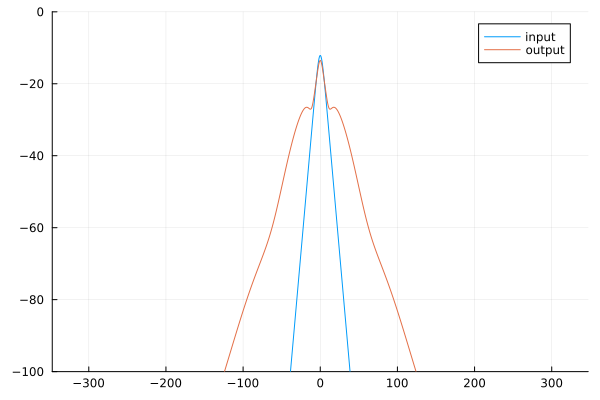

In [37]:

SP1 = 10log10.(abs2.(fftshift(fft(u0)/N)))
SP2 = 10log10.(abs2.(fftshift(fft(sol)/N)))

plot(ifftshift(ν)/1e12, SP1, label="input")
plot!(ifftshift(ν)/1e12, SP2, label="output")
ylims!(-100,0)

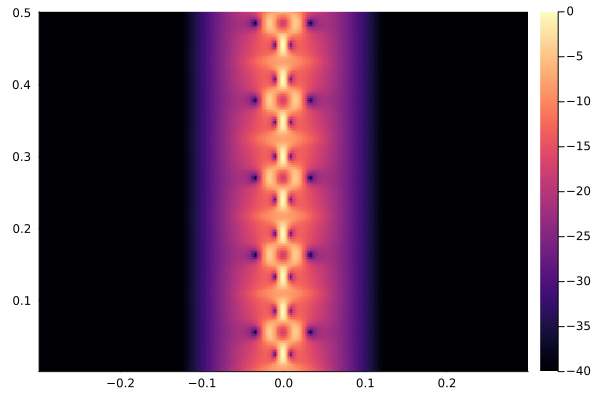

In [38]:
TT =  -0.3e-12 .<= t .<= 0.3e-12
SOL2 = abs2.(reverse(SOL, dims=1)[TT, 1:10:size(SOL)[2]])
SOL2 = SOL2 ./maximum(SOL2)
MIT = 10log10.((SOL2'))
heatmap(t[TT]*1e12, (1:size(SOL2)[2])*L/size(SOL2)[2], MIT, cmap = :magma, clims=(-40,0))

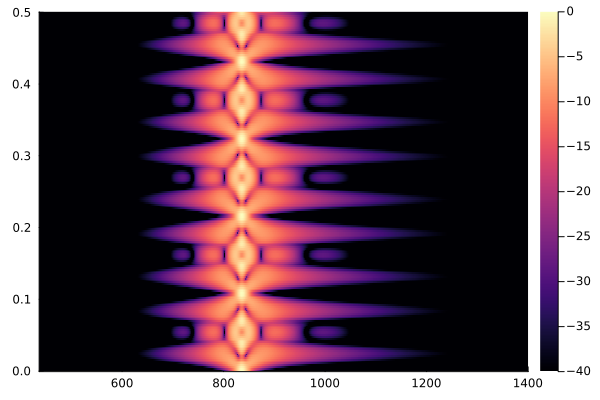

In [39]:


V =  (fftshift(reverse(ω)) .+ ω0)
W = (2pi*c ./ V * 1e9)
widx = 400 .<= W .<= 1400

M2 = reverse(ifftshift(M,1),dims=1)
SOL2 = abs2.(M2[widx, 1:10:size(M)[2]])
SOL2 = SOL2 ./maximum(SOL2)
MIT = 10log10.((SOL2'))

z = (1:10:size(SOL)[2])*L/size(SOL)[2]

heatmap(W[widx], z, MIT, cmap = :magma, clims = (-40,0))